## Libraries

In [4]:
import os
import h5py
import cv2

import scipy.ndimage as sp
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

## Data Loading

In [5]:
def load(dbname, dataset):
    '''
    dbname is the path to the database hdf file, dataset is the dataset name.
    returns a pandas dataframe and a dictionary with meta data for the dataset.
    '''
    attrs = None
    with h5py.File(dbname) as f:
        if dataset not in f.keys():
            raise ValueError('Can\'t find dataset. Available keys are: ' + str(f.keys()))
        try:
            df = pd.DataFrame(dict((k, f[dataset][k][:].ravel()) for k in f[dataset].keys()))
        except ValueError:
            raise RuntimeError('Not all fields have the same length:' +
                str(dict((k, f[dataset][k][:].ravel().shape) for k in f[dataset].keys())))
        if len(f[dataset].attrs.keys())>0:
            attrs = dict((k, f[dataset].attrs[k]) for k in  f[dataset].attrs.keys())
    return df, attrs

In [6]:
os.chdir('/Users/hyunwoogu/Dropbox/2018Autumn/GradThesis/EyeTracking_data/')

In [7]:
Data, attrs = load("etdb_v1.0.hdf5", "Face Discrim.")

## Data Processing

In [8]:
Data.columns.values

array(['SUBJECTINDEX', 'category', 'chain', 'condition', 'dataset_nr',
       'end', 'filenumber', 'fix', 'isref', 'phase', 'start', 'trial',
       'x', 'y'], dtype=object)

#### Counts and Duration

In [9]:
Data['counts'] = Data.groupby(['SUBJECTINDEX','trial']).cumcount()
Data.loc[:, 'Duration'] = Data.loc[:,'end'] - Data.loc[:,'start']

DataFirst = Data.loc[Data.counts == 0, :]
DataFirst = DataFirst.assign(UnCen = (DataFirst.end < 1450)) 

#### Right Censoring

In [10]:
Data.loc[(Data.counts==0) & (Data.end > 1450),['start', 'end', 'x', 'y', 'counts']].shape

(115, 5)

#### Face Feature Window

In [11]:
ChopSize = (80,60) ## pieces (x,y)
Data.loc[:, 'CumIndex'] = (Data.loc[:,'x']//ChopSize[0]) * ChopSize[0] + ((1200-Data.loc[:,'y'])//ChopSize[1])

#### Mean Duration by Face Features

In [12]:
def transparent_cmap(cmap, trans = 0.9, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, trans, N+4)
    return mycmap

transparent_cmap(plt.cm.bwr)

#### Averaging the faces

In [13]:
FileNames = os.listdir('21/')

w,h=Image.open('21/' + FileNames[0]).size
N=len(FileNames)

arr=np.zeros((h,w,3),np.float)

for im in FileNames:
    imarr= np.array(Image.open('21/' + im),dtype=np.float)
    arr=arr+imarr/N

arr=np.array(np.round(arr),dtype=np.uint8)
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
# out.show()

img = cv2.imread("Average.png", 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

#### Frequency plot

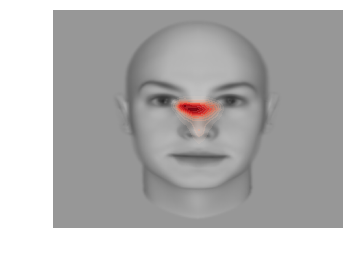

In [11]:
fig = plt.figure()

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax = sns.kdeplot(Data.loc[(Data.counts==0),'x'], Data.loc[(Data.counts==0),'y'], shade = True, 
                 cmap = transparent_cmap(plt.cm.Reds, trans=.99), gridsize=100)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)

plt.show()

#### Duration plot

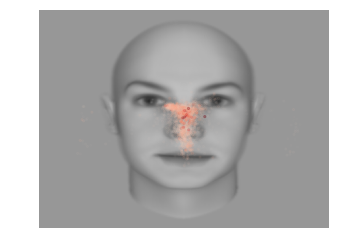

In [21]:
random.seed(13)

XwinSize = 500
YwinSize = 130

coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

s = np.arange(Data.loc[(Data.counts==0),'x'].shape[0])
np.random.shuffle(s)

ax.scatter((Data.loc[(Data.counts==0),'x'])[s], (Data.loc[(Data.counts==0),'y'])[s],\
            c=(Data.loc[(Data.counts==0),'Duration'])[s], s=5, cmap=transparent_cmap(plt.cm.Reds, trans=.3))

#rect1 = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect1)
#rect2 = patches.Rectangle(coord2,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect2)
#rect3 = patches.Rectangle(coord3,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect3)

plt.show()

In [ ]:
library(survival) ;
library(KMsurv) ;
data("bmt")
head(bmt)
bmt1 = with(bmt, bmt[group==1,])
bmt2 = with(bmt, bmt[group==2,])
bmt3 = with(bmt, bmt[group==3,])
만약 X에 exponential distribution을 가정한다면 아래와 같은 survival curve를 계산할 수 있습니다.

lambda <- sum(bmt1$d3)/sum(bmt1$t2)
print(lambda)
curve( exp(-lambda*x), from=0, to=max(bmt1$t2)+1, ylab='S(t)', xlab='time', main='Parametric survival function estimation')

#### Drawing Windows on the Face

In [ ]:
Data.shape

In [ ]:
Data_index = Data.loc[(Data.counts==0)]
Data_index = Data_index.groupby(['CumIndex']).mean()
Data_index.index.name = 'CumIndex'
Data_index.reset_index(inplace=True)
Data_index = Data_index.loc[(Data_index.CumIndex >= 0) & (Data_index.CumIndex < 20*20),\
                            ['CumIndex', 'Duration']]
Data_index = Data_index.set_index('CumIndex').reindex(range(0,20*20)).fillna(0).reset_index()
Data_index = Data_index.Duration.values.reshape(20,20)

plt.imshow(Data_index, cmap='Reds', interpolation='nearest')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

In [ ]:
Data['SUBJECTINDEX'==6,:]

In [ ]:
coord1 = (720, 440) ## x coord (from left), y coord (from top) 
#coord2 = (720, 550)
#coord3 = (720, 740)
XwinSize = 150
YwinSize = 150

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

Start = 200
End = 210

rect = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

In [ ]:
coord1 = (720, 440) ## x coord (from left), y coord (from top) 
#coord2 = (720, 550)
#coord3 = (720, 740)
XwinSize = 150
YwinSize = 150

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

Start = 200
End = 210

rect = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

#### "Final" Windows on the Face

In [ ]:
## x coord (from left), y coord (from top) 
coord1 = (560, 420) # Eye Left
coord2 = (850, 420) # Eye Right
coord3 = (720, 590) # Nose
coord4 = (720, 800) # Mouth

XwinSize = 150
YwinSize = 150

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
rect4 = patches.Rectangle(coord4,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect4)

plt.show()

In [ ]:
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x = np.random.randn(1000)
y = np.random.randn(1000)

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

#### Optimal Window : A Greedy Search

In [ ]:
def countFixations(startX, startY, XwinSize=500, YwinSize=130):
    res = Data.loc[(Data.counts==0) & 
                   (Data.x>=startX) & (Data.x<=startX+XwinSize) &
                   (Data.y>=startY) & (Data.y<=startY+YwinSize) ,'start'].shape[0]
    return(res)

In [ ]:
def meanDurations(startX, startY, XwinSize=130, YwinSize=130):
    res = np.mean(Data.loc[(Data.counts==0) & 
                           (Data.x>=startX) & (Data.x<=startX+XwinSize) &
                            (Data.y>=startY) & (Data.y<=startY+YwinSize) ,'Duration'])
    return (res)

In [ ]:
## Greedy Search

XwinSize=150
YwinSize=150

SegsX = np.arange(0, 1600-XwinSize, 20)
SegsY = np.arange(0, 1200-YwinSize, 20)

countRes = []
for i in SegsX:
    for j in SegsY:
        countRes.append((i,j,countFixations(i,j)))

A = np.array(countRes)[np.argsort(-np.array(countRes)[:,2]),:]

In [ ]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(B[:,0]+75, B[:,1]+75, c=B[:,2], cmap=mycmapB)
plt.show()

#### Map of Importance

In [ ]:
def expMLEfinder(x, y, Xwin, Ywin):
    sum_t = sum(DataFirst.loc[(DataFirst.x >= x) & (DataFirst.x < x + Xwin) & \
                              (DataFirst.y >= y) & (DataFirst.y < y + Ywin) , 'Duration'])
    
    sum_delta = sum(DataFirst.loc[(DataFirst.x >= x) & (DataFirst.x < x + Xwin) & \
                                          (DataFirst.y >= y) & (DataFirst.y < y + Ywin) ,'UnCen'])
    if sum_delta==0 :
        return(0)
    
    else: return(sum_t/sum_delta)

In [ ]:
numSliceX = 50
numSliceY = 50

XwinSize = 1600/numSliceX
YwinSize = 1200/numSliceY

SegsX = np.arange(0, 1600-XwinSize, XwinSize)
SegsY = np.arange(0, 1200-YwinSize, YwinSize)

res = []
for j in SegsY:
    for i in SegsX:
        res.append(expMLEfinder(i,j, XwinSize, YwinSize))

res = np.reshape(res, [numSliceY-1, numSliceX-1])        

In [16]:
DataFirst_i = DataFirst.loc[DataFirst.SUBJECTINDEX ==6, :]

In [17]:
def expMLEfinder(x, y, Xwin, Ywin):
    sum_t = sum(DataFirst_i.loc[(DataFirst_i.x >= x) & (DataFirst_i.x < x + Xwin) & \
                              (DataFirst_i.y >= y) & (DataFirst_i.y < y + Ywin) , 'Duration'])
    
    sum_delta = sum(DataFirst_i.loc[(DataFirst_i.x >= x) & (DataFirst_i.x < x + Xwin) & \
                                          (DataFirst_i.y >= y) & (DataFirst_i.y < y + Ywin) ,'UnCen'])
    if sum_delta==0 :
        return(0)
    
    else: return(sum_t/sum_delta)

numSliceX = 50
numSliceY = 50

XwinSize = 1600/numSliceX
YwinSize = 1200/numSliceY

SegsX = np.arange(0, 1600-XwinSize, XwinSize)
SegsY = np.arange(0, 1200-YwinSize, YwinSize)

res = []
for j in SegsY:
    for i in SegsX:
        res.append(expMLEfinder(i,j, XwinSize, YwinSize))

res = np.reshape(res, [numSliceY-1, numSliceX-1])        

In [23]:
res

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

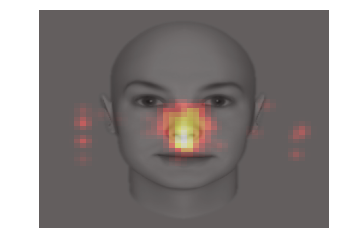

In [20]:
plt.figure()

plt.imshow(img, alpha=20) # for image
plt.axis('off')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.imshow(gaussian_filter(res, sigma=.8), cmap='hot', alpha=.4, extent=(xmin,xmax,ymin,ymax))

plt.show()

In [67]:
os.chdir("../")

In [68]:
os.getcwd()

'/Users/hyunwoogu/Dropbox/2018Autumn/GradThesis/EyeTracking_data'

In [69]:
res1 = pd.read_csv('ExpHeat.csv', delimiter=',')

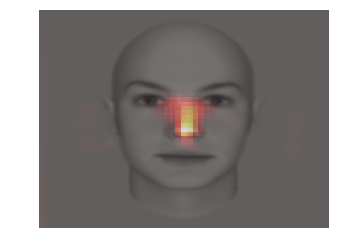

In [70]:
plt.figure()

plt.imshow(img, alpha=20) # for image
plt.axis('off')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.imshow(gaussian_filter(res1, sigma=.8), cmap='hot', alpha=.4, extent=(xmin,xmax,ymin,ymax))

plt.show()

In [73]:
res2 = pd.read_csv('WeibHeat.csv', delimiter=',')

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


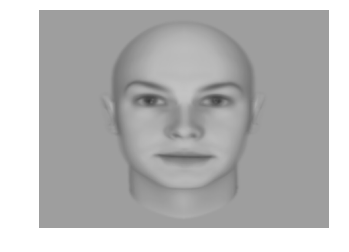

In [74]:
plt.figure()

plt.imshow(img, alpha=20) # for image
plt.axis('off')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.imshow(gaussian_filter(res2, sigma=.8), cmap='hot', alpha=.4, extent=(xmin,xmax,ymin,ymax))

plt.show()

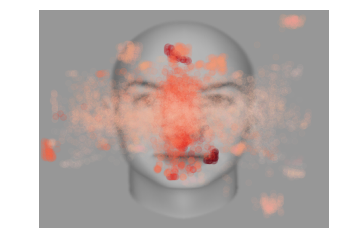

In [32]:
XwinSize=50
YwinSize=50

SegsX = np.arange(0, 1600-XwinSize, 10)
SegsY = np.arange(0, 1200-YwinSize, 10)

meanRes = []
for i in SegsX:
    for j in SegsY:
        meanRes.append((i,j,meanDurations(i,j)))
        
B = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]

fig, ax = plt.subplots()

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

X = B[:,0]+XwinSize/2
Y = B[:,1]+YwinSize/2

X = sp.filters.gaussian_filter(X, sigma = 1, order = 0)
Y = sp.filters.gaussian_filter(Y, sigma = 1, order = 0)

ax.scatter(X, Y, c=B[:,2], cmap=transparent_cmap(plt.cm.Reds, trans=.2))

plt.show()

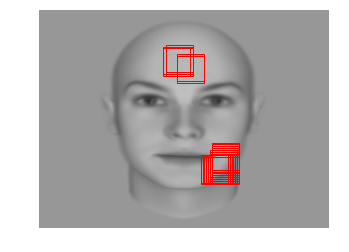

In [90]:
XwinSize = 150
YwinSize = 150

coord1 = (720, 440) ## x coord (from left), y coord (from top) 

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

Start = 0
End = 30

for i in range(Start, End+1) :
    rect = patches.Rectangle(C[i, [0,1]],XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

#### Fixation proportion as a function of time

In [12]:
def FixationProp(t):
    return(sum((Data.loc[:,'start'] <= t) & (Data.loc[:,'end'] >= t)))

In [ ]:
def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'end'] >= t)))

In [86]:
# Coordinates are notated "intuitively"
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=390) & (Data.y<=540), 'Duration'].shape # original eye
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=660) & (Data.y<=810) ,'start'].shape # reverse eye
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=480) & (Data.y<=630) ,'start'].shape # original concen
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'].shape # reverse concen
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=720) & (Data.y<=870) ,'start'].shape # original mouth
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=330) & (Data.y<=480) ,'start'].shape # reverse mouth

(1183,)

In [163]:
coord = (520, 390) ## x coord (from left), y coord (from top) 
coord = (720, 720)
# coord = (720, 550)

coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
# coord4 = (900, 410)

def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'end'] >= t)))

def FixationProp2(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'end'] >= t)))

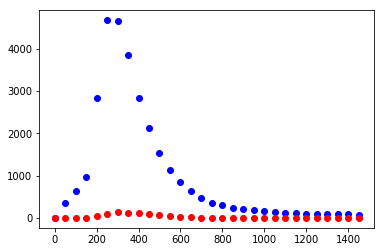

In [164]:
timeSegs = np.arange(0, 1500, 50)
props1 = [FixationProp1(x) for x in timeSegs]
props2 = [FixationProp2(x) for x in timeSegs]

plt.plot(timeSegs, props1, 'bo')
plt.plot(timeSegs, props2, 'ro')

plt.show()

**Maxtrix Method**

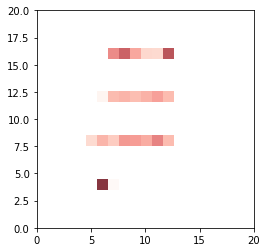

In [179]:
Data_index = Data.loc[(Data.counts==0)]
Data_index = Data_index.groupby(['CumIndex']).mean()
Data_index.index.name = 'CumIndex'
Data_index.reset_index(inplace=True)
Data_index = Data_index.loc[(Data_index.CumIndex >= 0) & (Data_index.CumIndex < 20*20),\
                            ['CumIndex', 'Duration']]
Data_index = Data_index.set_index('CumIndex').reindex(range(0,20*20)).fillna(0).reset_index()
Data_index = Data_index.Duration.values.reshape(20,20)

plt.imshow(Data_index, cmap='Reds', interpolation='nearest')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

## Image Handling

In [ ]:
fig = plt.figure()

for i, Num in enumerate((21, 5, 1, 17, 29, 13)):
    
    FileNum = Data[Data['filenumber']==Num]
    adr = '21/' + str(Num) + '.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "23" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(FileNum['x'], FileNum['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

#### Salience map by fixation area

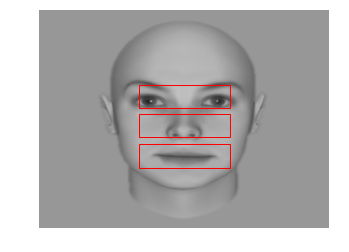

In [225]:
coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
#coord4 = (900, 410)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
#rect4 = patches.Rectangle(coord4,150,150,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect4)

plt.show()

In [54]:
os.getcwd()

'/Users/hyunwoogu/Dropbox/2018Autumn/GradThesis/EyeTracking_data'

In [58]:
os.chdir("./Figures/")

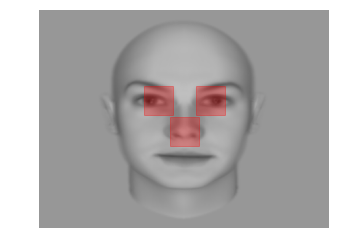

In [64]:
coord1 = (575, 420)
coord2 = (865, 420)
coord3 = (720, 590)
Winsize = 160

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,Winsize,Winsize,linewidth=1,edgecolor='r',facecolor='r', alpha=.3)
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,Winsize,Winsize,linewidth=1,edgecolor='r',facecolor='r', alpha=.3)
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,Winsize,Winsize,linewidth=1,edgecolor='r',facecolor='r', alpha=.3)
ax.add_patch(rect3)
#rect4 = patches.Rectangle(coord4,150,150,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect4)

plt.savefig("face_ROI.png")
plt.show()

#### Salience map by fixation order

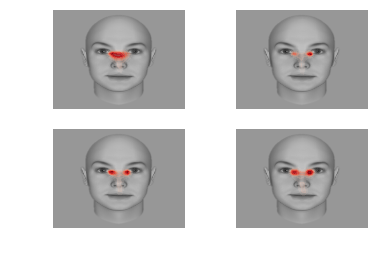

In [125]:
fig = plt.figure()

for i, Order in enumerate((1, 3, 5, 7)):
    
    GazeOrder = Data[Data['counts']==Order]
    adr = '21/1.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "22" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(GazeOrder['x'], GazeOrder['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

NameError: name 'mycmap' is not defined

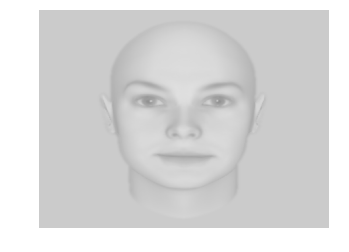

In [14]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(Data.loc[(Data.counts==0),'x'], Data.loc[(Data.counts==0),'y'],\
            c=Data.loc[(Data.counts==0),'Duration'], cmap=mycmap)
plt.show()


## Survival Analysis

## Prediction